##Educação em geofísica
Material didático - algoritmos para aulas de geofísica
#Realce de anomalias - Derivadas em x, y e z

Citação deste material: Szameitat, L.S.A., Bongiolo, A.B.S. (in prep.). Educação em geofísica: recursos computacionais para tratamento de dados magnetométricos e gravimétricos em sala de aula. Boletim Paranaense de Geociências.

####Referencias
#####• Blakely, R. (1996). Potential Theory in Gravity and Magnetic Applications.Cambridge University, 464p.

Importar bibliotecas

In [1]:
import numpy as np
import scipy.fftpack
from math import radians, sin, cos, sqrt
import matplotlib.pyplot as plt
#import seaborn as sb
import pandas as pd
import seaborn as sb

#Funções
Funções para trabalhar com os dados do campo magnético anômalo, com base nos algoritmos de Blakely (1996).

In [2]:
def Kvalue(i, j, nx, ny, dkx, dky):
    '''
    Parametros
    ----------
    i, j - indices
    nx, ny -  numero de amostras em x e y
    dkx, dky -
    '''
    nyqx = nx / 2 + 1
    nyqy = ny / 2 + 1
    kx = float()
    ky = float()
    if j <= nyqx:
        kx = (j-1) * dkx
    else:
        kx = (j-nx-1) * dkx
    if i <= nyqy:
        ky = (i-1) * dky
    else:
        ky = (i-ny-1) * dky
    return kx, ky

def Derivada(grid, axis, nx, ny, dkx, dky):

    # FFT, entrada grid de 2 dimensões
    gridfft = scipy.fftpack.fft2(grid)

    # Filtro
    # Grid - de matriz para vetor
    gridfft = np.reshape(gridfft, nx*ny)
    # Cria um vetor complexo
    gridfft_filt = np.zeros(nx*ny).astype(complex)
    if axis == 'z':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = sqrt(kx**2 + ky**2)
                gridfft_filt[ij-1] = gridfft[ij-1]*k**1 #filtro
    elif axis == 'y':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = kx
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    elif axis == 'x':
        for j in range(1, ny+1):
            for i in range(1, nx+1):
                ij = (j-1) * nx + i
                kx, ky = Kvalue(i, j, nx, ny, dkx, dky)
                k = ky
                gridfft_filt[ij-1] = gridfft[ij-1]*k*complex(0, 1)
    else:
        return print ('Tipo não suportado: ', axis)

    #de vetor para matriz 2D novamente
    gridfft_filt = np.reshape(gridfft_filt, (ny, nx))
    #iFFT, entrada grid de 2 dimensões
    gridfft_filt = scipy.fftpack.ifft2(gridfft_filt)
    grid_out = np.reshape(gridfft_filt.real, (ny, nx))

    return grid_out


#Arquivo de entrada
Carregar arquivo de dados no ambiente. O arquivo deve conter colunas de coordenadas (x,y) e campo anômalo.

In [3]:
#Opção 1 - Arquivo para exercício

arquivo = 'https://raw.githubusercontent.com/lszam/ensino/main/geof_filtros/pentanomaly.csv'

#Opção 2 - Arquivo próprio
#from google.colab import files
#import io

#uploaded=files.upload()
#arquivo = ' ' #inserir o nome do arquivo

Abrir e visualizar o arquivo de entrada:

In [4]:
dados = pd.read_csv(arquivo, delimiter = ",")
dados

,LESTE,NORTE,ANOM
0,5.725889e+06,7.858880e+06,0.0
1,5.726135e+06,7.858880e+06,0.0
2,5.726381e+06,7.858880e+06,0.0
3,5.726628e+06,7.858880e+06,0.0
4,5.726874e+06,7.858880e+06,0.0
...,...,...,...
70351,5.785221e+06,7.929044e+06,0.0
70352,5.785467e+06,7.929044e+06,0.0
70353,5.785713e+06,7.929044e+06,0.0
70354,5.785959e+06,7.929044e+06,0.0


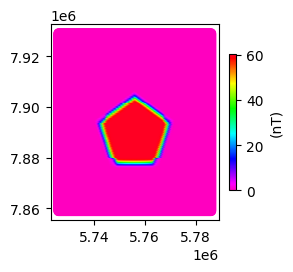

In [5]:
#Plotar mapa
plt.figure(figsize=(3, 3))  #tamanho da figura
entrada_anom = plt.scatter(dados.LESTE, dados.NORTE, c=dados.ANOM, cmap='gist_rainbow_r')
plt.colorbar(entrada_anom, label="(nT)", shrink=0.6) #barra de cores
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

*Organizando os grids de entrada. Cria grids de duas dimensões para os valores leste, norte e campo anômalo.*

In [6]:
# .to_numpy() converte os valores de dentro da série tipo Pandas em um array NumPy
vetor_LESTE = dados.LESTE.to_numpy()
vetor_NORTE = dados.NORTE.to_numpy()
vetor_ANOM = dados.ANOM.to_numpy()

#Elementos a leste e a norte
pontos_LESTE=[]
pontos_NORTE=[]

#Adicionar valores não repetidos
[pontos_LESTE.append(item) for item in vetor_LESTE if not pontos_LESTE.count(item)]
[pontos_NORTE.append(item) for item in vetor_NORTE if not pontos_NORTE.count(item)]

#Salvar número de itens a leste e a norte
n_l = np.size(pontos_LESTE)
n_n = np.size(pontos_NORTE)

#Obter a distancia em x e y
dX, dY = np.abs(pontos_LESTE[0]-pontos_LESTE[1]), np.abs(pontos_NORTE[0]-pontos_NORTE[1])

#Grid
grid_LESTE, grid_NORTE = np.meshgrid(pontos_LESTE, pontos_NORTE) #mesh
grid_ANOM = np.reshape(vetor_ANOM, (n_n, n_l)) #de 1D para 2D

#Salva as posições dos prismas como array
pontos_LESTE = np.array(pontos_LESTE)
pontos_NORTE = np.array(pontos_NORTE)


#Derivadas em X, Y e Z

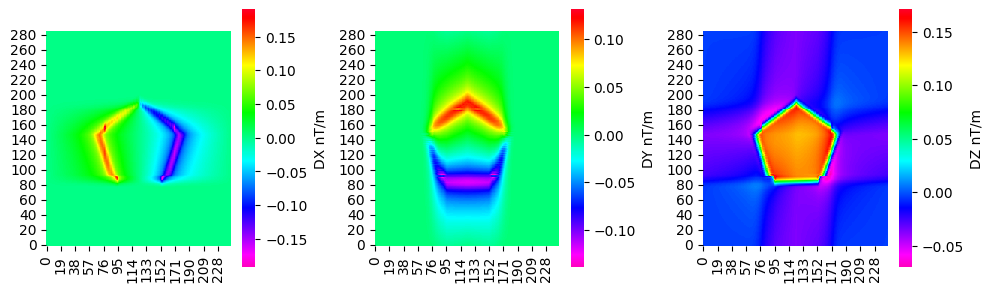

In [8]:
π = np.pi
dkx = 2. * π / (n_l * dX)
dky = 2. * π / (n_n * dY)

# Filtros
grid_DX1 = Derivada(grid_ANOM, 'x', n_l, n_n, dkx, dky)
grid_DY1 = Derivada(grid_ANOM, 'y', n_l, n_n, dkx, dky)
grid_DZ1 = Derivada(grid_ANOM, 'z', n_l, n_n, dkx, dky)

# Plotar mapas
import seaborn as sb

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
sb_plot1 = sb.heatmap(grid_DX1, cmap="gist_rainbow_r", cbar_kws={'label': 'DX nT/m'})
sb_plot1.invert_yaxis()
plt.gca().set_aspect("equal")
plt.subplot(2, 3, 2)
sb_plot2 = sb.heatmap(grid_DY1, cmap="gist_rainbow_r", cbar_kws={'label': 'DY nT/m'})
sb_plot2.invert_yaxis()
plt.gca().set_aspect("equal")
plt.subplot(2, 3, 3)
sb_plot3 = sb.heatmap(grid_DZ1, cmap="gist_rainbow_r", cbar_kws={'label': 'DZ nT/m'})
sb_plot3.invert_yaxis()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

In [10]:
dados = dados.assign(DX1 = np.reshape(grid_DX1, (n_l*n_n)))
dados = dados.assign(DY1 = np.reshape(grid_DY1, (n_l*n_n)))
dados = dados.assign(DZ1 = np.reshape(grid_DZ1, (n_l*n_n)))
dados

,LESTE,NORTE,ANOM,DX1,DY1,DZ1
0,5.725889e+06,7.858880e+06,0.0,3.801213e-19,-1.340345e-17,-0.004153
1,5.726135e+06,7.858880e+06,0.0,1.328039e-18,-1.138412e-17,-0.004146
2,5.726381e+06,7.858880e+06,0.0,1.777102e-18,-1.330181e-17,-0.004139
3,5.726628e+06,7.858880e+06,0.0,2.370952e-18,-1.150779e-17,-0.004132
4,5.726874e+06,7.858880e+06,0.0,2.442419e-18,-1.133330e-17,-0.004125
...,...,...,...,...,...,...
70351,5.785221e+06,7.929044e+06,0.0,-2.747865e-18,3.088494e-19,-0.004185
70352,5.785467e+06,7.929044e+06,0.0,-2.538235e-18,2.196568e-18,-0.004178
70353,5.785713e+06,7.929044e+06,0.0,-2.520904e-18,1.849073e-18,-0.004171
70354,5.785959e+06,7.929044e+06,0.0,-2.658269e-18,2.698223e-18,-0.004165


Salvar a saída como arquivo csv

In [11]:
dados.to_csv("derivadas_py.csv")